In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# 设置参数
mpl.rcParams["pdf.fonttype"] = 42  # 保留字体
sc.settings.verbosity = 4  # 输出细节
sc._settings.ScanpyConfig.n_jobs = -1  # 使用所有核心
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=600,
    facecolor="white",
    frameon=False,  # remove frame
)

In [3]:
## 7.1 读取标准化后的数据
adata = sc.read("anndata_normalization.h5ad")
# print(adata.X.max(), adata.layers["log1p_norm"].max(), sep="\n")
print(adata.X.max(), adata.layers["scran_normalization"].max(), sep="\n")

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


4380.0
8.844777397637154


In [4]:
adata.raw = adata.copy()
## TODO:这次没有counts
adata.layers["counts"] = adata.X.copy()
# adata = adata[adata.obs["sample"] != "diab7", :]

我们将深度归一化和平方根变换后的数据版本保存到adata.layers['sqrt_norm']，以便我们稍后可以使用它们绘制归一化计数。有关为什么在这里使用平方根变换的更多背景信息，请参阅Wagner (2020)。

In [5]:
import numpy as np

adata.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(adata, inplace=False)["X"]
)

normalizing counts per cell
    finished (0:00:00)


In [6]:
adata

AnnData object with n_obs × n_vars = 66568 × 17065
    obs: 'C0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_antibody', 'nFeature_antibody', 'patients', 'sampletag', 'organs', 'percent.mt', 'percent.ribo', 'log10GenesPerUMI', 'batch', 'integrated_snn_res.0.5', 'seurat_clusters', 'samples', 'doublet.score', 'predicted.doublet', 'cluster', 'doublet', 'patients_organ', 'sample', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'size_factors'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mea

In [7]:
## 7.2 取高变基因
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat",  # seurat_v3:期望原始counts
    n_top_genes=2000,  # 500 - 5000，根据7.2.1看6000时均匀些
    layer="scran_normalization",  # 这里可以试试soupX_counts
    batch_key="batch",
    subset=False,  # 取子集后anndata中只有1000个基因,普通去批次只用hvg
)
"""会发现新增了额外的列
    - highly_variable_nbatches- 发现每个基因高度可变的批次数量
    - highly_variable_intersection- 每个基因在每批中是否存在很大差异
    - highly_variable- 合并每批结果后是否将每个基因选择为高度可变
"""
# adata_batch.var
# # 识别高变基因的方法
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5,batch_key="batch")
# sc.pp.highly_variable_genes(adata, n_top_genes=1000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    Gene indices [6638, 7123, 8788] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    the 2000 top genes correspond to a normalized dispersion cutoff of 0.4763643695642478
    Gene indices [6514, 6515, 6654, 7147, 8830] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    the 2000 top genes correspond to a normalized dispersion cutoff of 0.49627689158995203
    Gene indices [6609, 6749, 7241] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    the 2000 top genes correspond to a normalized dispersion cutoff of 0.56267670905306
    Gene indices [6202, 6208, 6470, 8558] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.


'会发现新增了额外的列\n    - highly_variable_nbatches- 发现每个基因高度可变的批次数量\n    - highly_variable_intersection- 每个基因在每批中是否存在很大差异\n    - highly_variable- 合并每批结果后是否将每个基因选择为高度可变\n'

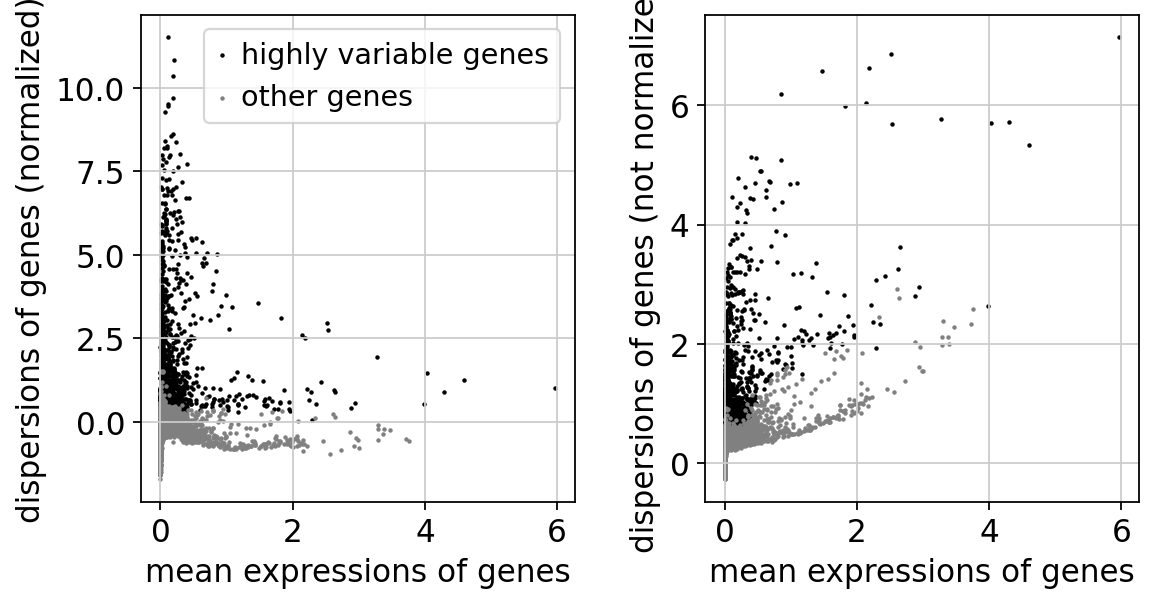

In [8]:
sc.pl.highly_variable_genes(adata)

In [9]:
# 小鼠
# markers = [
#     # "Stat3",
#     "Arg1",
#     "Itgb2",  # "CD11b",
#     "Ly6g",
#     "Ly6c1",
#     "Ly6c2",
# ]
# 大鼠
# markers = [
# "Cd3",    # T细胞标志
# "Cd4",    # helper T细胞标志
# "Cd8",    # 细胞毒性T细胞标志
# "Cd19",   # B细胞标志
# "Cd11b",  # 单核细胞/巨噬细胞标志
# "Cd11c",  # 树突状细胞标志
# "Cd16",   # 自然杀伤细胞标志
# "Cd56",   # 自然杀伤细胞标志
# "Foxp3",  # 调节性T细胞标志
# "Cd25",   # 活化T细胞和调节性T细胞标志
# "Cd127",  # 记忆T细胞标志
# "Cd45R",  # B细胞标志
# "Cd68",   # 巨噬细胞标志
# "F4/80",  # 小鼠/大鼠巨噬细胞标志
# "Ly6G",   # 嗜中性粒细胞标志
# ]
# 人
markers = [
    "CD33",
    "ITGB2",
    "FUT4",
    "CEACAM8",
    "CD14",
    "HLA-DRA",
    "HLA-DRB5",
    "HLA-DRB1",
]

In [10]:
# # 皮尔逊残差高变基因
# sc.experimental.pp.highly_variable_genes(
#     adata, flavor="pearson_residuals", n_top_genes=3000, batch_key="batch"
# )

In [11]:
# import numpy as np
# import matplotlib.pyplot as plt


# # 假设 adata, markers 已经定义

# fig, ax = plt.subplots(figsize=(6, 6))  # 改为单个图形的大小

# hvgs = adata.var["highly_variable"]

# # 绘制所有基因
# ax.scatter(
#     adata.var["mean_counts"], adata.var["residual_variances"], s=3, edgecolor="none"
# )
# # 绘制高变异基因
# ax.scatter(
#     adata.var["mean_counts"][hvgs],
#     adata.var["residual_variances"][hvgs],
#     c="tab:red",
#     label="selected genes",
#     s=3,
#     edgecolor="none",
# )
# # 绘制已知标记基因
# ax.scatter(
#     adata.var["mean_counts"][np.isin(adata.var_names, markers)],
#     adata.var["residual_variances"][np.isin(adata.var_names, markers)],
#     c="k",
#     label="known marker genes",
#     s=10,
#     edgecolor="none",
# )
# # 在每个标记基因上添加文本标注
# for marker in markers:
#     # 获取基因的索引
#     marker_index = np.where(adata.var_names == marker)[0][0]
#     # 获取基因的均值和残差方差
#     mean_count = adata.var["mean_counts"][marker_index]
#     residual_variance = adata.var["residual_variances"][marker_index]
#     # 在图上为标记基因添加文本标注
#     # ax.text(mean_count, residual_variance, marker, fontsize=9)
#     # 在图上为标记基因添加文本标注，加白色背景
#     ax.text(
#         mean_count,
#         residual_variance,
#         marker,
#         fontsize=9,
#         bbox=dict(
#             facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.2"
#         ),
#     )

# ax.set_xscale("log")
# ax.set_xlabel("mean expression")
# ax.set_yscale("log")
# ax.set_ylabel("residual variance")
# ax.set_title("gene expression vs. residual variance")

# ax.spines["right"].set_visible(False)
# ax.spines["top"].set_visible(False)
# ax.yaxis.set_ticks_position("left")
# ax.xaxis.set_ticks_position("bottom")

# plt.legend()
# plt.savefig("./figures/04-高变基因中的marker.pdf")
# plt.show()

In [12]:
markers = [marker for marker in markers if marker in adata.var_names]
# 检查每个基因是否为高变基因
is_hvg_array = adata.var.loc[markers, "highly_variable"]
# 打印结果
for gene, is_hvg in zip(markers, is_hvg_array):
    print(
    f"{gene} is {'a highly variable gene' if is_hvg else 'not a highly variable gene'}"
    )

CD33 is not a highly variable gene
ITGB2 is a highly variable gene
FUT4 is not a highly variable gene
CEACAM8 is not a highly variable gene
CD14 is a highly variable gene
HLA-DRA is a highly variable gene
HLA-DRB5 is a highly variable gene
HLA-DRB1 is a highly variable gene


In [13]:
adata = adata[:, adata.var["highly_variable"]]
adata

View of AnnData object with n_obs × n_vars = 66568 × 2000
    obs: 'C0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_antibody', 'nFeature_antibody', 'patients', 'sampletag', 'organs', 'percent.mt', 'percent.ribo', 'log10GenesPerUMI', 'batch', 'integrated_snn_res.0.5', 'seurat_clusters', 'samples', 'doublet.score', 'predicted.doublet', 'cluster', 'doublet', 'patients_organ', 'sample', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'size_factors'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'lo

computing PCA
    on highly variable genes
    with n_comps=50


/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


    finished (0:00:03)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


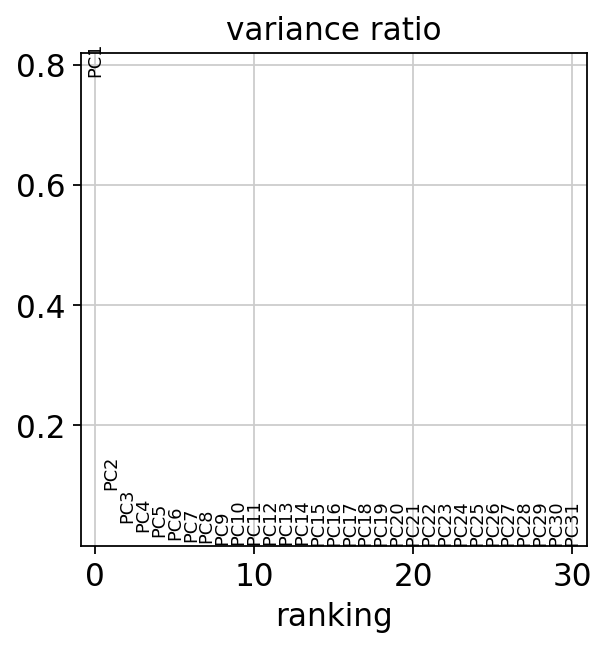

In [14]:
sc.pp.pca(
    adata,
    n_comps=50,
    use_highly_variable=True,
    random_state=123,
)
sc.pl.pca_variance_ratio(adata)

## 预览


In [15]:
sc.pp.neighbors(
    adata,
    n_neighbors=15,
    n_pcs=4,
    random_state=123,
)
sc.tl.umap(adata, min_dist=0.3, random_state=123)

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 4
    computed neighbors (0:00:20)
    computed connectivities (0:00:05)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:26)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:29)


/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


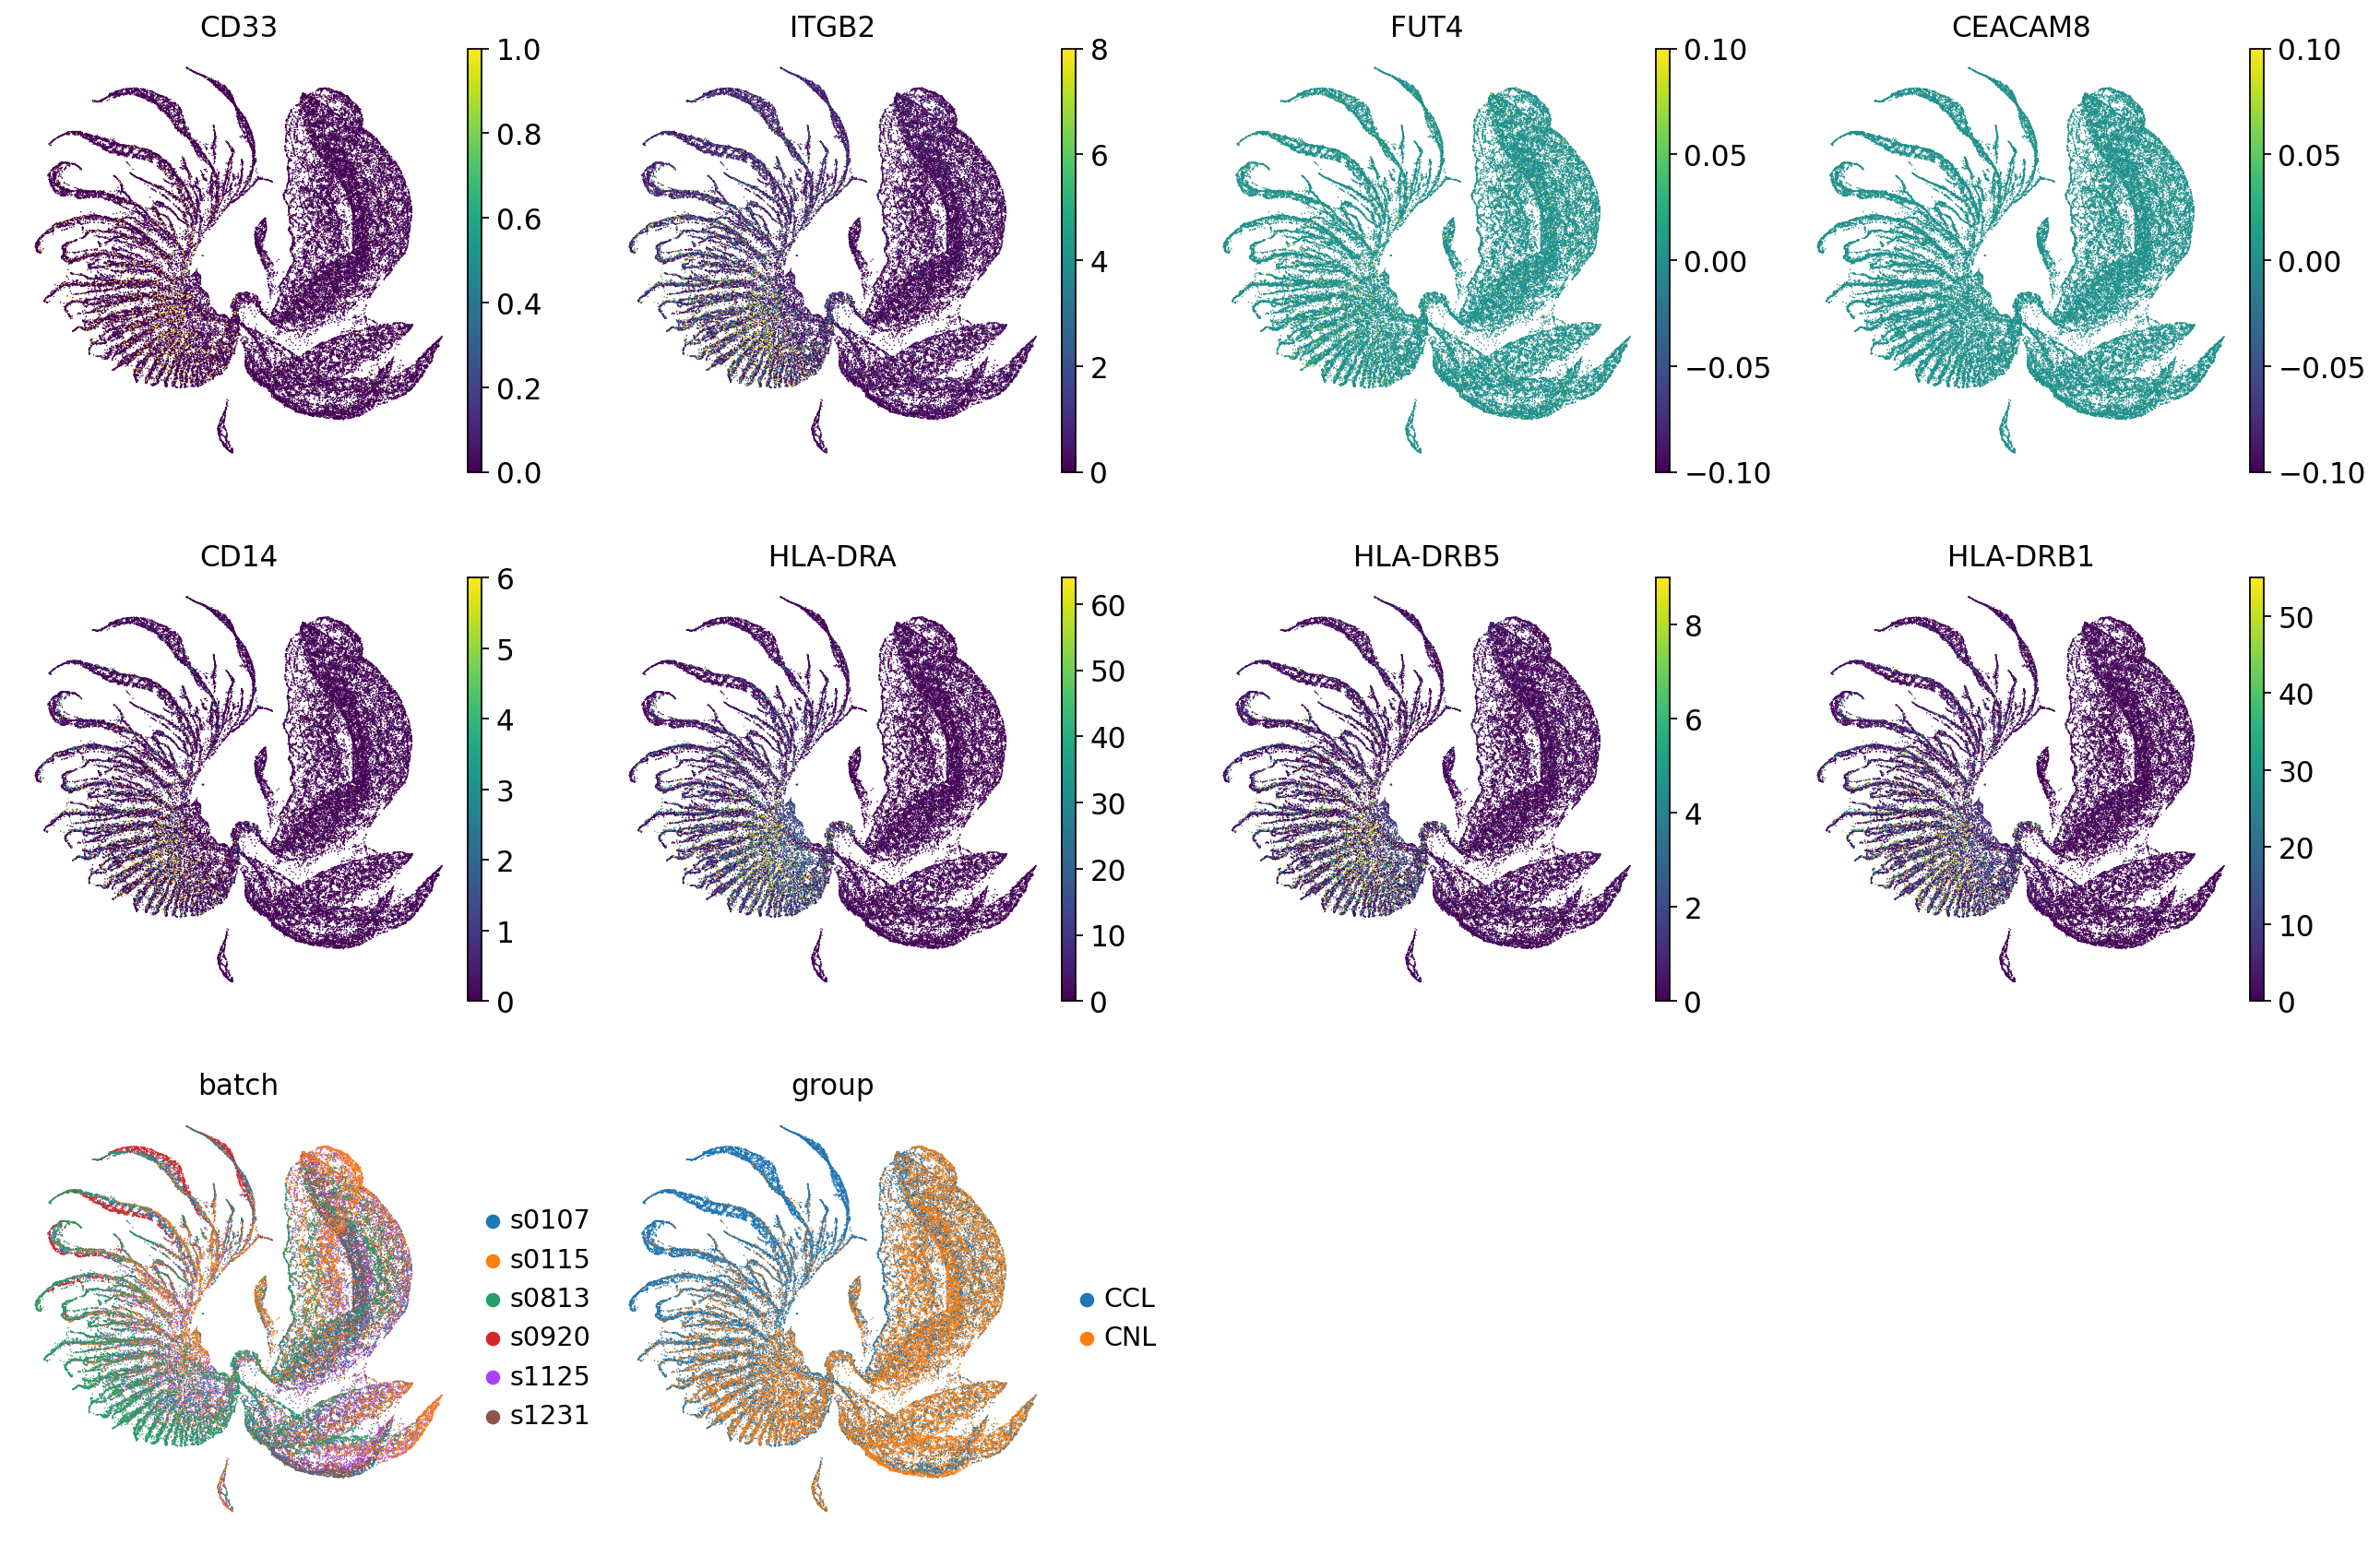

In [16]:
sc.pl.umap(
    adata,
    color=markers + ["batch"] + ["group"],
    vmin=0,
    vmax="p99",
    save="_marker速览.pdf",
    # layer="sqrt_norm",
)

In [17]:
adata.write("anndata_highly.h5ad")